# 引言
本次项目中，我们将使用计算机视觉技术来检测车辆并对其进行跟踪

# 项目软件框架
下图是车辆检测的实现流程图：
XXXXXXXXXXX
具体内容如下：
>* 在有标签的训练数据集上进行Histogram of Oriented Gradients(HOG)特征提取
>* Normalize 这些特征，并随机化数据集
>* 训练线性SVM分类器
>* 实现一个滑动窗口技术，并使用训练好的分类器在图片中寻找车辆
>* 实现一个流处理机制，并通过一帧一帧地创建循环检测的热图来去除异常值及跟踪车辆
>* 为检测到的车辆估计一个边界框

# Features
本项目，我们使用一些有标签的训练数据：汽车图片、无汽车图片，训练数据在all文件夹中可以找到
有汽车地图片标签为1，无汽车的图片标签为0
我们先读取数据，看下数据的分布

In [1]:
# import libs
import glob
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
import pickle
SEED = 2018
%matplotlib inline
# Read dataset image
vehicle_images = glob.glob('all/vehicles/GTI*/*.png')
none_vehicle_images = glob.glob('all/non-vehicles/*/*.png')
cars = []
notcars = []
for image in vehicle_images:
    cars.append(image)
for image in none_vehicle_images:
    notcars.append(image)
print('Dataset size:Cars {} | NotCars {}'.format(len(cars),len(notcars)))
rate = len(cars)/len(notcars)*1.0
if rate<2 and rate>0.5:
    print('DataSet is balance')
else:
    print('DataSet is not balance')

Dataset size:Cars 2826 | NotCars 8968
DataSet is not balance


接下来我们分别随机选取一张有汽车及无汽车的图片

The size of car is 64
The size of notcar is 64


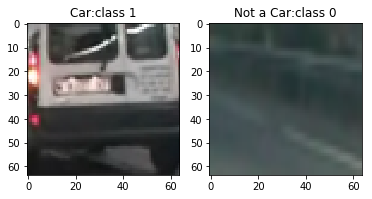

In [2]:
# random choose
rand_car = np.random.choice(len(cars))
rand_notcar = np.random.choice(len(notcars))
this_car = mpimg.imread(cars[rand_car])
this_notcar = mpimg.imread(notcars[rand_notcar])

print('The size of car is {}'.format(len(this_car)))
print('The size of notcar is {}'.format(len(this_notcar)))
plt.figure(1)
plt.subplot(121)
plt.title('Car:class 1')
plt.imshow(this_car)
plt.subplot(122)
plt.title('Not a Car:class 0')
plt.imshow(this_notcar)
plt.show()

# HOG feature extraction
接下来，我们来提取Histogram of oriented Gradients(HOG)特征。
有关HOG特征相关的信息，大家可以参考：[HOG](https://www.learnopencv.com/histogram-of-oriented-gradients/)
提取HOG特征的基本步骤如下：
>* 第一阶段为了减少图像亮度的影响需要对图片做一个全局的归一化。
>* 第二阶段计算图像的一阶导数，从而捕捉图像的轮廓及纹理信息。
>* 第三阶段旨在产生对局部图像内容敏感的编码（cell）
>* 第四阶段，归一化（block）
>* 最后将HOG descriptor 转化成分类器需要的特征向量

In [3]:
## 
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    '''
    function:Extract HOG image and HOG features of a given image
    orient: number of bins for the orientation
    pix_per_cell: size of a cell
    cell_per_block: nber of cells per block
    vis(Boolean) :visualize the HOG image
    feature_vec(Boolean):return the features as a feature vector
    By default,the function uses transform_sqrt(apply power law compression to normalize the image before processing)
    '''
    if vis == True:
        features,hog_image = hog(img,orientations=orient,
                                pixels_per_cell=(pix_per_cell,pix_per_cell),
                                cells_per_block = (cell_per_block,cell_per_block),
                                transform_sqrt=True,
                                visualise=vis,feature_vector=feature_vec)
        return features,hog_image
    else:
        features = hog(img,orientations=orient,
                       pixels_per_cell=(pix_per_cell,pix_per_cell),
                      cells_per_block=(cell_per_block,cell_per_block),
                      transform_sqrt=True,
                      visualise=vis,feature_vector=feature_vec)
        return features

def bin_spatial(img,size=(32,32)):
    '''
    Binned Color Feature
    img:original image
    size:target size of the image
    output:feature vector
    '''
    features = cv2.resize(img,size).ravel()
    #print(cv2.resize(img,size).shape)(8,8,3)=>192
    return features

def color_hist(img,nbins=32,bins_range=(0,256)):
    '''
    Color histogram features for each channel of the original image
    img: original image
    nbins: number of bins of the histogram
    output:concatenate feature vector
    '''
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    #Concatenate the histograms into a sigle feature vector
    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))#48
    #print(channel1_hist)
    # Return the individual histograms into a single feature vector 
    return hist_features

def extract_features(imgs,color_space="RGB",spatial_size=(32,32),
                    hist_bins=32,orient=9,
                    pix_per_cell=8,cell_per_block=2,hog_channel=0,
                    spatial_feat=True,hist_feat=True,hog_feat=True,
                    hog_vis=False):
    '''
    Feature extractor:extract features from a list of images
    The function calls bin_spatial(),color_hist() and get_hog_features
    '''
    #create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if hog_vis == False:
            image = image.astype(np.float32)/255
        # apply color conversion if other than 'RGB'
        # color conversion
        if color_space in ['HSV','LUV','HLS','YUV','YCrCb']:
            feature_image = cv2.cvtColor(image,eval('cv2.COLOR_RGB2'+color_space))
        else: feature_image = np.copy(image)
        # Image size: add all pixels of reduced image as vector
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image,size=spatial_size)
            #print('spatial features shape:',spatial_features.shape)
            file_features.append(spatial_features)
        # Histogram of reduced image: add histogram as a vector
        if hist_feat == True:
            hist_features = color_hist(feature_image,nbins=hist_bins)
            file_features.append(hist_features)
        #HOG of reduced image: add HOG as feature vector
        if hog_feat == True:# Call get_hog_features() with vis=False ,feature_vec = True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    if hog_vis:
                        hog_feature,hog_image = get_hog_features(feature_image[:,:,channel],
                                                                orient,pix_per_cell,cell_per_block,
                                                                vis=True,feature_vec=True)
                        #print(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY).dtype)
                        res = cv2.addWeighted(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY),0.1,
                                              ((hog_image/np.max(hog_image))*255).astype(np.float32),0.1,0.0)
                        # Plot the examples
                        fig = plt.figure()
                        plt.title(channel)
                        plt.subplot(131)
                        plt.imshow(image,cmap='gray')
                        plt.title('Original Image')
                        plt.subplot(132)
                        plt.imshow(hog_image,cmap='gray')
                        plt.title('HOG')
                        plt.subplot(133)
                        plt.imshow(res,cmap='gray')
                        plt.title('overlapped')
                        plt.show()
                    else:
                        hog_feature = get_hog_features(feature_image[:,:,channel],
                                                      orient,pix_per_cell,cell_per_block,
                                                      vis=False,feature_vec=True)
                    #print('hog feature shape:',hog_feature.shape)
                    hog_features.append(hog_feature)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],orient,
                                               pix_per_cell,cell_per_block,vis=False,feature_vec = True)
            #Append the new feature vector to the features list
            #print('hog features shape:',hog_features.shape)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        #print(np.concatenate(file_features).shape)
    # return list of feature vectors
    return features

# Settings for feature extraction

In [4]:
color_space = 'YCrCb'  # ['RGB','HSV','LUV','HLS','YUV',''YCrCb']
orient = 12#HOG orientations
pix_per_cell = 8#HOG pixels per cell
cell_per_block = 2 #HOG cells per block
hog_channel = 'ALL'  # ['0','1','ALL']
spatial_size = (8,8) #Spatial binning dimensions
hist_bins = 16  #Number of histogram bins
hist_range = bins_range = (0,256)
spatial_feat = True #spatial features
hist_feat = False # histogram features
hog_feat = True # hog features

# Visualization of Hog Image

Image adress: all/non-vehicles/GTI/image1686.png


/home/ora/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


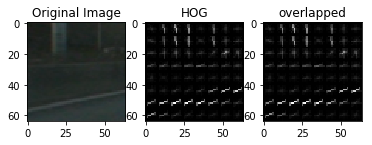

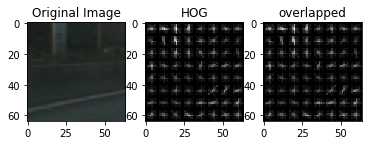

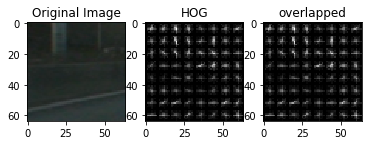

In [5]:
# randomly select example
rand_img = np.random.choice(np.arange(0,len(notcars),1))

print('Image adress:',notcars[rand_img])
feat = extract_features([notcars[rand_img]],color_space=color_space,
                        spatial_size=spatial_size,hist_bins=hist_bins,
                        orient=orient,pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel,spatial_feat=spatial_feat,
                        hist_feat=hist_feat,hog_feat=hog_feat,hog_vis=True
                       )

# Build Dataset with feature extraction

In [6]:
car_features = extract_features(cars,color_space=color_space,
                               spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,
                                pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                hog_channel=hog_channel,spatial_feat=spatial_feat,
                                hist_feat=hist_feat,hog_feat=hog_feat)

notcar_features = extract_features(notcars,color_space=color_space,
                                  spatial_size=spatial_size,hist_bins=hist_bins,
                                  orient=orient,pix_per_cell=pix_per_cell,
                                  cell_per_block=cell_per_block,
                                  hog_channel=hog_channel,spatial_feat=spatial_feat,
                                  hist_feat=hist_feat,hog_feat=hog_feat)
# Group cars and notcars images in a single array
X = np.vstack((car_features,notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))
#Normalize data:fit a per-column scaler
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

#Split up data into randomized training and test sets(shuffe included)
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size=0.2,random_state=SEED)

print('Using:',orient,'orientations',pix_per_cell,
     'pixels per cell and ',cell_per_block,'cells per block')
print('Feature vector length:',len(X_train[0]))
print('Mean of example 0{}|std {}'.format(np.mean(X_train[10]),np.std(X_train[0])))

/home/ora/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 12 orientations 8 pixels per cell and  2 cells per block
Feature vector length: 7248
Mean of example 0-0.05479098608161728|std 0.8436106482861411


# Run classifier
## SVC
这里我们运行线性支持向量机

In [7]:
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train,y_train)
t2 = time.time()

print(round(t2-t,2),'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC=',round(svc.score(X_train,y_train),4))
print('Test Accuracy of SVC=',round(svc.score(X_test,y_test),4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts:',svc.predict(X_test[0:n_predict]))
print('For these',n_predict,'labels:',y_test[0:n_predict])
t2 = time.time()
print(round(t2-t,5),'Seconds to predict',n_predict,'labels with SVC')

22.9 Seconds to train SVC...
Train Accuracy of SVC= 1.0
Test Accuracy of SVC= 0.9818
My SVC predicts: [0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
For these 10 labels: [0. 1. 0. 0. 1. 1. 0. 0. 1. 0.]
0.00101 Seconds to predict 10 labels with SVC


## Logistic Regression Classifier
接下来我们运行逻辑回归分类器

In [9]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(max_iter=10)
t = time.time()
lrc.fit(X_train,y_train)
t2 = time.time()
print(round(t2-t,2),'Seconds to train LRC...')
# Check the score of the LRC
print('Train Accuracy of LRC=',round(lrc.score(X_train,y_train),4))
print('Test Accuracy of LRC=',round(lrc.score(X_test,y_test),4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My LRC predicts:',lrc.predict(X_test[0:n_predict]))
print('For these',n_predict,'labels:',y_test[0:n_predict])
t2 = time.time()
print(round(t2-t,5),'Seconds to predict',n_predict,'labels with LRC')

27.1 Seconds to train LRC...
Train Accuracy of LRC= 1.0
Test Accuracy of LRC= 0.9852
My LRC predicts: [0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
For these 10 labels: [0. 1. 0. 0. 1. 1. 0. 0. 1. 0.]
0.00169 Seconds to predict 10 labels with LRC


## Multi-Layer Perceptron Classifer
最后我们来运行多层感知分类器

In [10]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=SEED)
t = time.time()
mlp.fit(X_train,y_train)
t2 = time.time()
print(round(t2-t,2),'Seconds to train MLP...')
# Check the score of the LRC
print('Train Accuracy of MLP=',round(mlp.score(X_train,y_train),4))
print('Test Accuracy of MLP=',round(mlp.score(X_test,y_test),4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My MLP predicts:',mlp.predict(X_test[0:n_predict]))
print('For these',n_predict,'labels:',y_test[0:n_predict])
t2 = time.time()
print(round(t2-t,5),'Seconds to predict',n_predict,'labels with LRC')

21.28 Seconds to train MLP...
Train Accuracy of MLP= 1.0
Test Accuracy of MLP= 0.9953
My MLP predicts: [0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
For these 10 labels: [0. 1. 0. 0. 1. 1. 0. 0. 1. 0.]
0.00294 Seconds to predict 10 labels with LRC


# Save the model
保存模型

In [11]:
model_combine = 'model.p'
try:
    with open(model_combine,'wb') as pfile:
        pickle.dump(
        {
            'X_dataset':X,
            'y_dataset':y,
            'svc':svc,
            'lrc':lrc,
            'mlp':mlp,
            'X_scaler':X_scaler,
            'color_space':color_space,
            'spatial_size':spatial_size,
            'hist_bins':hist_bins,
            'orient':orient,
            'pix_per_cell':pix_per_cell,
            'cell_per_block':cell_per_block,
            'hog_channel':hog_channel,
            'spatial_feat':spatial_feat,
            'hist_feat':hist_feat,
            'hog_feat':hog_feat
        },
            pfile,pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to',model,':',e)
    raise